In [1]:
library(tidyverse)

library(grid)
library(gridExtra)
library(patchwork)

source("../evaluation_utils/plots_eda.R")
# source("../evaluation_utils/evaluation_funcs.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite



In [2]:
# R version
R.version.string

[1] "R version 4.3.3 (2024-02-29)"

In [3]:
# ggplot2, umap version
packageVersion("ggplot2")
packageVersion("umap")

[1] ‘3.5.2’

[1] ‘0.2.10.0’

In [4]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

# Load data

In [5]:
data_path <- "../evaluation_data/simulated/"

before_correction <- list()
central_corrected <- list()
fed_corrected <- list()
metadata <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    for (lab in c("lab1", "lab2", "lab3")) {
        # read in the data
        lab_data <- read.csv(paste0(data_path, mode, "/before/", lab, "/intensities.tsv"), sep = "\t", header = TRUE, check.names = F)
        # if before_correction[[mode]] is empty, initialize it
        if (is.null(before_correction[[mode]])) {
            before_correction[[mode]] <- lab_data
        } else {
            before_correction[[mode]] <- merge(before_correction[[mode]], lab_data, by = "rowname", all = TRUE)
        }
    }
    # before_correction[[mode]] <- read.csv(paste0(data_path, mode, "/all_intensities.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    before_correction[[mode]] <- before_correction[[mode]] %>% column_to_rownames("rowname")
    central_corrected[[mode]] <- read.csv(paste0(data_path, mode, "/after/intensities_R_corrected.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    fed_corrected[[mode]] <- read.csv(paste0(data_path, mode, "/after/FedApp_corrected_data_smpc.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    # fed_corrected[[mode]] <- central_corrected[[mode]]

    metadata[[mode]] <- read.csv(paste0(data_path, mode, "/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

    # metadata[[mode]]$file <- rownames(metadata[[mode]])
    rownames(metadata[[mode]]) <- metadata[[mode]]$file
    metadata[[mode]]$condition <- as.factor(metadata[[mode]]$condition )
    metadata[[mode]]$lab <- as.factor(metadata[[mode]]$lab)

    # order the columns in intensity dataframes
    before_correction[[mode]] <- before_correction[[mode]][, rownames(metadata[[mode]])]
    central_corrected[[mode]] <- central_corrected[[mode]][rownames(before_correction[[mode]]), rownames(metadata[[mode]])]
    fed_corrected[[mode]] <- fed_corrected[[mode]][rownames(before_correction[[mode]]), rownames(metadata[[mode]])]

    cat(mode, "before correction:", nrow(before_correction[[mode]]), "rows\n")
    cat(mode, "after R correction:", nrow(central_corrected[[mode]]), "rows\n")
    cat(mode, "after FedSim correction:", nrow(fed_corrected[[mode]]), "rows\n")
    cat(mode, "metadata:", nrow(metadata[[mode]]), "rows\n\n")
}

balanced before correction: 6000 rows
balanced after R correction: 6000 rows
balanced after FedSim correction: 6000 rows
balanced metadata: 600 rows

mild_imbalanced before correction: 6000 rows
mild_imbalanced after R correction: 6000 rows
mild_imbalanced after FedSim correction: 6000 rows
mild_imbalanced metadata: 600 rows

strong_imbalanced before correction: 6000 rows
strong_imbalanced after R correction: 6000 rows
strong_imbalanced after FedSim correction: 6000 rows
strong_imbalanced metadata: 600 rows



# Checks

## Diagnostic plots

In [6]:
# supress warnings
options(warn=-1)

In [7]:
# plot_pca_uncorrected <- list()
# plot_pca_corrected <- list()

# for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

#     before_with_zeros <- before_correction[[mode]]
#     before_with_zeros[is.na(before_with_zeros)] <- 0
#     after_with_zeros <- fed_corrected[[mode]]
#     after_with_zeros[is.na(after_with_zeros)] <- 0

#     plot_pca_uncorrected[[mode]] <- pca_plot(
#         before_with_zeros, metadata[[mode]],
#         title = paste("Before correction"),
#         quantitative_col_name = "file", 
#         col_col = "condition", shape_col="lab", show_legend=F, cbPalette=c("#a70a66", "#2a609d"))

#     plot_pca_corrected[[mode]] <- pca_plot(
#         after_with_zeros, metadata[[mode]],
#         title = paste("After FedRBE correction"),
#         quantitative_col_name = "file", 
#         col_col = "condition", shape_col="lab", show_legend=T, cbPalette=c("#a70a66", "#2a609d"))

#     layout <- (plot_pca_uncorrected[[mode]] + plot_pca_corrected[[mode]])
#     layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
#     options(repr.plot.width=6, repr.plot.height=3)
#     print(layout)
# }



In [ ]:
plot_pca_uncorrected <- list()
plot_pca_corrected <- list()

layouts <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- fed_corrected[[mode]]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    plot_pca_uncorrected[[mode]] <- pca_plot(
        before_with_zeros, metadata[[mode]],
        title = paste("Before correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=T, cbPalette=c("#a70a66", "#2a609d"),
        point_size = 1
        )

    plot_pca_corrected[[mode]] <- pca_plot(
        after_with_zeros, metadata[[mode]],
        title = paste("After FedRBE correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=F, cbPalette=c("#a70a66", "#2a609d"),
        point_size = 1
        )

    layout <- plot_pca_uncorrected[[mode]] /
              plot_pca_corrected[[mode]]
    layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
}



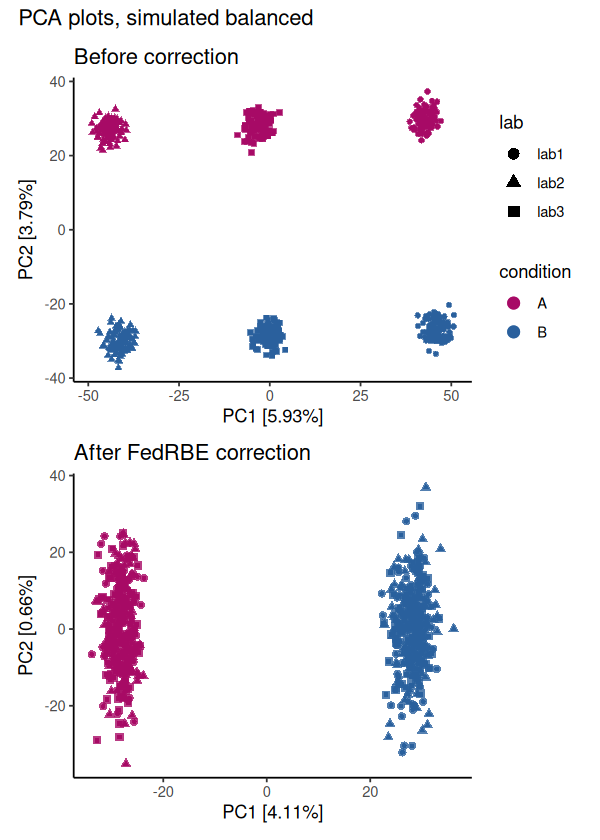

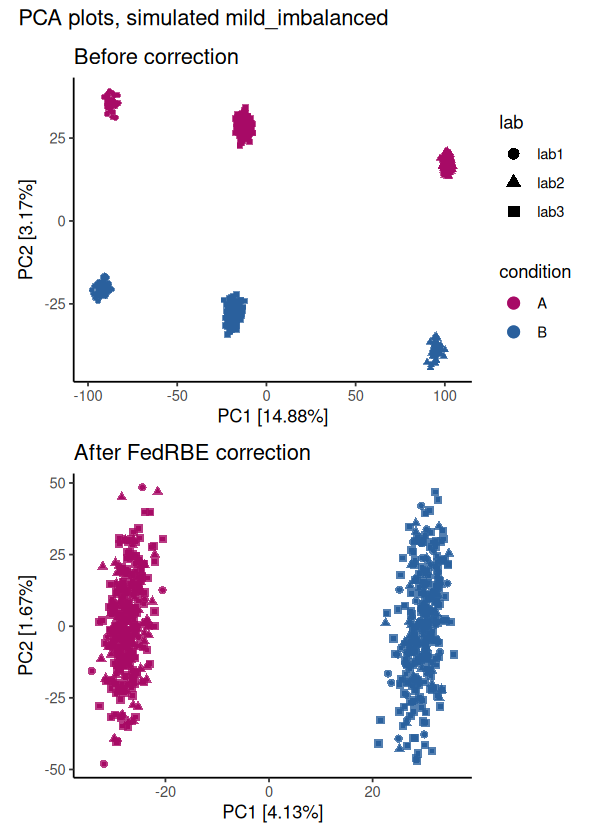

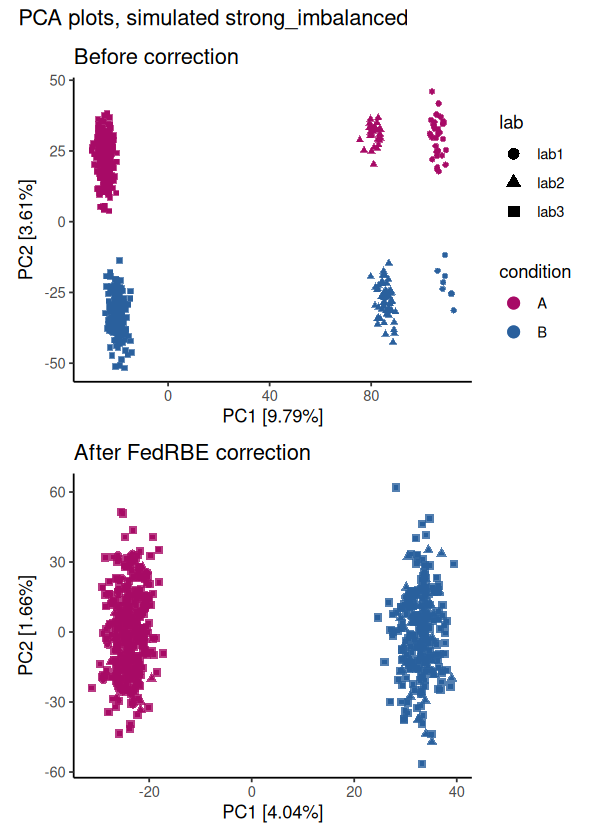

In [56]:
options(repr.plot.width=5, repr.plot.height=7, dpi=600)

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced")) {
    plot_corrected_one <- plot_pca_corrected[[mode]] + 
        geom_point(size = 2, alpha = 0.8)

    plot_uncorrected_one <- plot_pca_uncorrected[[mode]] + 
        geom_point(size = 1.5, alpha = 0.7)


    # change the legend marker size (the kegend was added using theme(legend.position = "none"))
    plot_uncorrected_one <- plot_uncorrected_one +
        guides(
            colour = guide_legend(
            override.aes = list(size = 3)   # ← larger filled circles
            ),
            shape  = guide_legend(
            override.aes = list(size = 3)   # ← larger shape symbols
            )
        ) 

    layout <- plot_uncorrected_one /
              plot_corrected_one

    layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
    print(layout)
}

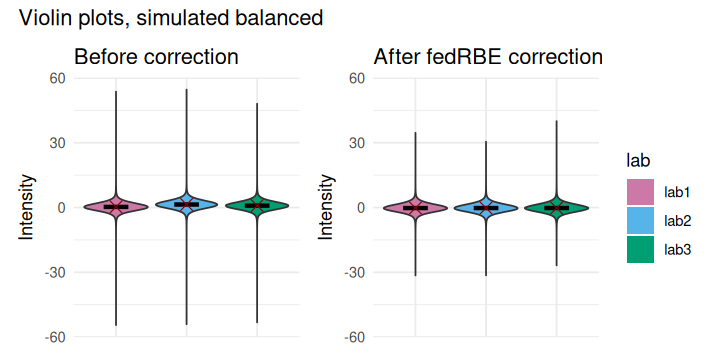

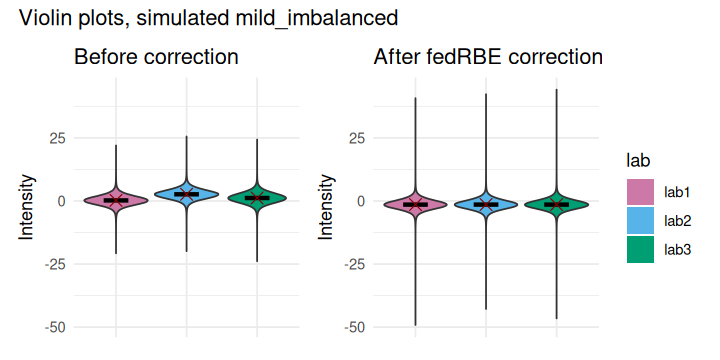

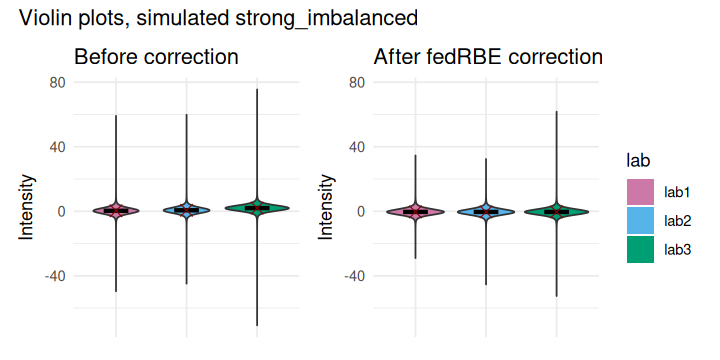

In [9]:
violins_uncorrected <- list()
violins_fed <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    # # Determine the shared Y-axis limits
    y_min <- min(before_correction[[mode]], fed_corrected[[mode]], na.rm = TRUE)
    y_max <- max(before_correction[[mode]], fed_corrected[[mode]], na.rm = TRUE)
    y_limits <- c(y_min, y_max)

    violins_uncorrected[[mode]] <- boxplot_plot_groupped(
        before_correction[[mode]], metadata[[mode]], 
        title = paste("Before correction"),
        quantitativeColumnName = "file",
        color_col = "lab", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
    
    violins_fed[[mode]] <- boxplot_plot_groupped(
        fed_corrected[[mode]], metadata[[mode]], 
        title = paste("After fedRBE correction"),
        quantitativeColumnName = "file",
        color_col = "lab", remove_xnames = T, show_legend=T, y_limits = y_limits, cbPalette = cbPalette)

    options(repr.plot.width=6, repr.plot.height=3)
    layout <- violins_uncorrected[[mode]] | violins_fed[[mode]]
    layout <- layout + plot_annotation(paste0("Violin plots, simulated ", mode))
    print(layout)
}

In [10]:
# violins_uncorrected <- list()
# violins_fed <- list()

# for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

#     # # Determine the shared Y-axis limits
#     y_min <- min(before_correction[[mode]], fed_corrected[[mode]], na.rm = TRUE)
#     y_max <- max(before_correction[[mode]], fed_corrected[[mode]], na.rm = TRUE)
#     y_limits <- c(y_min, y_max)

#     violins_uncorrected[[mode]] <- boxplot_plot_groupped(
#         before_correction[[mode]], metadata[[mode]], 
#         title = paste("Before correction"),
#         quantitativeColumnName = "file",
#         color_col = "lab", remove_xnames = T, show_legend=T, y_limits = y_limits, cbPalette = cbPalette)
    
#     violins_fed[[mode]] <- boxplot_plot_groupped(
#         fed_corrected[[mode]], metadata[[mode]], 
#         title = paste("After fedRBE correction"),
#         quantitativeColumnName = "file",
#         color_col = "lab", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)

#  options(repr.plot.width=3.5, repr.plot.height=5.5)
#     layout <- violins_uncorrected[[mode]] /
#               violins_fed[[mode]]
#     layout <- layout + plot_annotation(paste0("Violin plots, simulated ", mode))
#     print(layout)
# }

In [11]:
# # pca and violins in one
# layout <- (plot_pca_uncorrected[["balanced"]] + plot_pca_corrected[["balanced"]]) /
#           (violins_uncorrected[["balanced"]] + violins_central[["balanced"]]) /
#             (plot_pca_uncorrected[["mild_imbalanced"]] + plot_pca_corrected[["mild_imbalanced"]]) /
#             (violins_uncorrected[["mild_imbalanced"]] + violins_central[["mild_imbalanced"]]) /
#             (plot_pca_uncorrected[["strong_imbalanced"]] + plot_pca_corrected[["strong_imbalanced"]]) /
#             (violins_uncorrected[["strong_imbalanced"]] + violins_central[["strong_imbalanced"]])

# options(repr.plot.width=10, repr.plot.height=18)
# layout 

##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [12]:
library(variancePartition)

Loading required package: limma



Loading required package: BiocParallel


Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




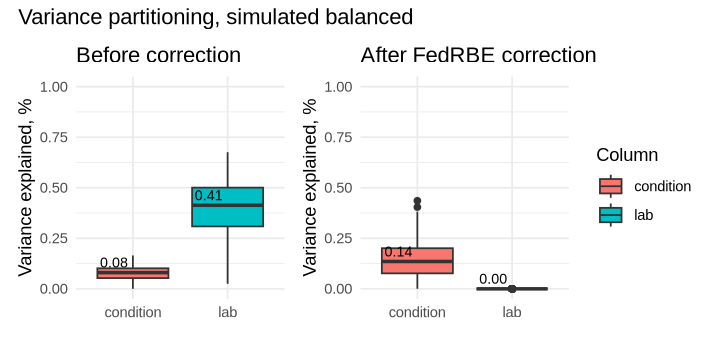

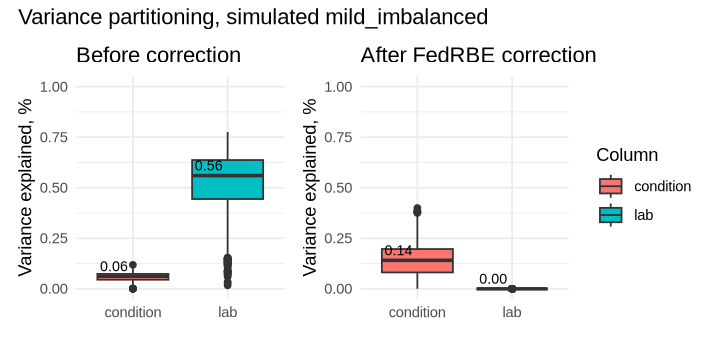

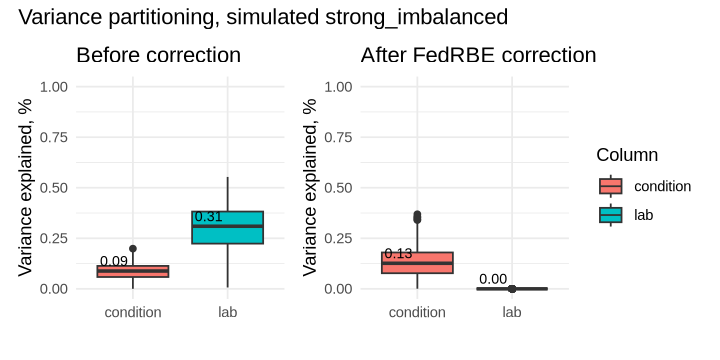

In [81]:
form <- ~ condition + lab

y_limits_values <- list(
    "balanced" = 0.51,
    "mild_imbalanced" = 0.62,
    "strong_imbalanced" = 0.6
)

lmpv_plot_uncorrected <- list()
lmpv_plot_fed <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]][1:2400,]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- fed_corrected[[mode]][1:2400,]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    lmpv_plot_uncorrected[[mode]] <- lmpv_plot(before_with_zeros, metadata[[mode]], 
        paste("Before correction"), show_legend=F, 
        # max_yval = y_limits_values[[mode]],
        form = form)
    lmpv_plot_fed[[mode]] <- lmpv_plot(after_with_zeros, metadata[[mode]], 
        paste("After FedRBE correction"), 
        # max_yval = y_limits_values[[mode]],
        form = form)

    layout <- lmpv_plot_uncorrected[[mode]] |  lmpv_plot_fed[[mode]]
    layout <- layout + plot_annotation(paste0("Variance partitioning, simulated ", mode))
    options(repr.plot.width=6, repr.plot.height=3)
    print(layout)
}


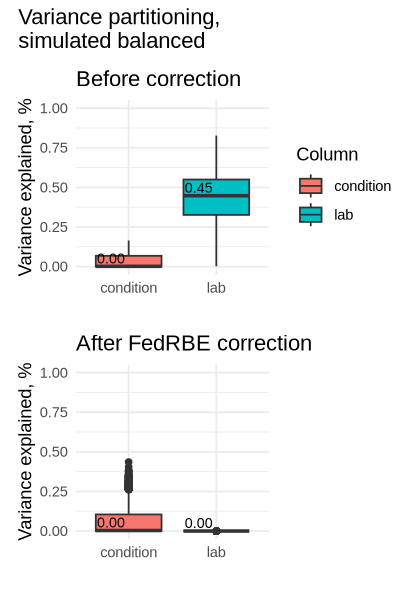

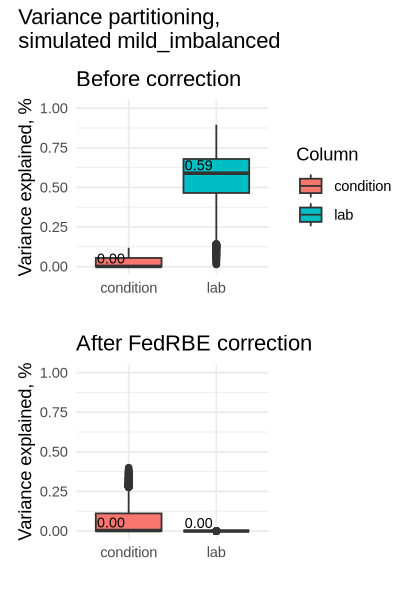

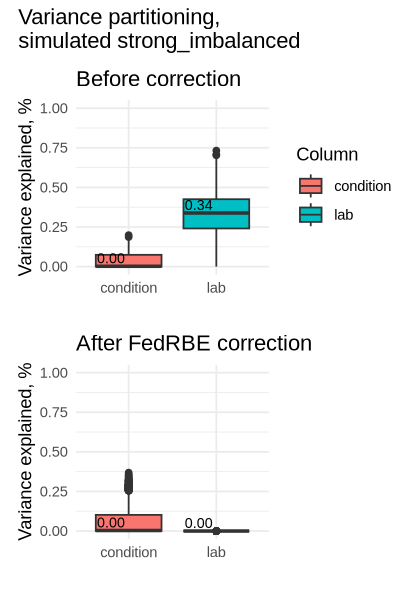

In [82]:

lmpv_plot_uncorrected <- list()
lmpv_plot_fed <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- fed_corrected[[mode]]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    lmpv_plot_uncorrected[[mode]] <- lmpv_plot(before_with_zeros, metadata[[mode]], 
        paste("Before correction"), show_legend=T, 
        # max_yval = y_limits_values[[mode]],
        form = form)
    lmpv_plot_fed[[mode]] <- lmpv_plot(after_with_zeros, metadata[[mode]], 
        paste("After FedRBE correction"), , show_legend=F, 
        # max_yval = y_limits_values[[mode]],
        form = form)

    layout <- lmpv_plot_uncorrected[[mode]] /
              lmpv_plot_fed[[mode]]
    layout <- layout + plot_annotation(paste0("Variance partitioning, \nsimulated ", mode))
    options(repr.plot.width=3.5, repr.plot.height=5)
    print(layout)
}


In [79]:
# layout <- (lmpv_plot_uncorrected[["balanced"]] + lmpv_plots_corrected[["balanced"]]) /
#             (lmpv_plot_uncorrected[["mild_imbalanced"]] + lmpv_plots_corrected[["mild_imbalanced"]]) /
#             (lmpv_plot_uncorrected[["strong_imbalanced"]] + lmpv_plots_corrected[["strong_imbalanced"]])

# options(repr.plot.width=10, repr.plot.height=10)
# layout

# Errors

In [9]:
for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){
    print(paste("Mode:", mode))
    differences <- calculated_differences(central_corrected[[mode]], fed_corrected[[mode]])
    cat("Min difference:", differences[2], "\n")
    cat("Mean difference:", differences[3], "\n")
    cat("Max difference:", differences[1], "\n")
    
    cat("\n")
}

[1] "Mode: balanced"
Min difference: 0 
Mean difference: 1.695675e-15 
Max difference: 5.329071e-14 

[1] "Mode: mild_imbalanced"
Min difference: 0 
Mean difference: 1.780761e-15 
Max difference: 5.329071e-14 

[1] "Mode: strong_imbalanced"
Min difference: 0 
Mean difference: 1.91856e-15 
Max difference: 5.329071e-14 

